## Application to a realistic case study
for Ensemble Refinement and Force-Field Fitting

In [1]:
import os
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('../../3_alphabetagamma/')

In [3]:
from MDRefine.MDRefine import load_data, normalize_observables, minimizer, unwrap_2dict, loss_function
from basic_functions_bayesian import local_density, run_Metropolis

look at the Kish size (or the relative entropy) during the MC sampling

### 1. load data

In [30]:
infos = {'global': {
    # 'path_directory': '../../3_alphabetagamma/MDRefine/tests/DATA_test',
    # DATA_test corresponds to stride = 1e4 and only one observable per type
    
    'path_directory': '../../3_alphabetagamma/DATA',
    
    'system_names': ['AAAA'],  # , 'CAAU'],  # , 'CCCC', 'GACC', 'UUUU', 'UCAAUC'],
    'g_exp': ['backbone1_gamma_3J', 'backbone2_beta_epsilon_3J', 'sugar_3J'],#, 'NOEs'],# , ('uNOEs', '<')],
    'forward_qs': ['backbone1_gamma', 'backbone2_beta_epsilon','sugar'],
    # 'obs': ['NOEs'],#, 'uNOEs'],
    'forward_coeffs': 'original_fm_coeffs'}}

stride = 100

In [31]:
def forward_model_fun(fm_coeffs, forward_qs, selected_obs=None):

    # 1. compute the cosine (which is the quantity you need in the forward model;
    # you could do this just once before loading data)
    forward_qs_cos = {}

    for type_name in forward_qs.keys():
        forward_qs_cos[type_name] = jnp.cos(forward_qs[type_name])

    # if you have selected_obs, compute only the corresponding observables
    if selected_obs is not None:
        for type_name in forward_qs.keys():
            forward_qs_cos[type_name] = forward_qs_cos[type_name][:,selected_obs[type_name+'_3J']]

    # 2. compute observables (forward_qs_out) through forward model
    forward_qs_out = {
        'backbone1_gamma_3J': fm_coeffs[0]*forward_qs_cos['backbone1_gamma']**2 + fm_coeffs[1]*forward_qs_cos['backbone1_gamma'] + fm_coeffs[2],
        'backbone2_beta_epsilon_3J': fm_coeffs[3]*forward_qs_cos['backbone2_beta_epsilon']**2 + fm_coeffs[4]*forward_qs_cos['backbone2_beta_epsilon'] + fm_coeffs[5],
        'sugar_3J': fm_coeffs[6]*forward_qs_cos['sugar']**2 + fm_coeffs[7]*forward_qs_cos['sugar'] + fm_coeffs[8] }

    return forward_qs_out

In [32]:
infos['global']['forward_model'] = forward_model_fun

In [33]:
infos['global']['names_ff_pars'] = ['sin alpha']  # , 'cos alpha']

def ff_correction(pars, f):
    # out = jnp.matmul(pars, (f[:, [0, 6]] + f[:, [1, 7]] + f[:, [2, 8]]).T)
    out = jnp.matmul(pars, (f[:, [0]] + f[:, [1]] + f[:, [2]]).T)
    return out

def ff_correction_hexamers(pars, f):
    out = jnp.matmul(pars, (f[:, [0, 10]] + f[:, [1, 11]] + f[:, [2, 12]] + f[:, [3, 13]] + f[:, [4, 14]]).T)
    return out

infos['global']['ff_correction'] = ff_correction
# infos['UCAAUC'] = {'ff_correction': ff_correction_hexamers}

In [34]:
data = load_data(infos, stride=stride)

loading data from directory...
loading  AAAA
done


### 2. normalize observables and find the optimal solution at given $\alpha$

In [9]:
name_mol = 'AAAA'

normalization: just once, at the beginning of Metropolis sampling

in order to simplify a (global) pre-factor in the Jeffreys prior

In [10]:
out = normalize_observables(data.mol[name_mol].gexp, data.mol[name_mol].g, weights=data.mol[name_mol].weights)

data.mol[name_mol].g = out[0]
data.mol[name_mol].gexp = out[1]
data.mol[name_mol].normg_mean = out[2]
data.mol[name_mol].normg_std = out[3]

In [11]:
result = minimizer(data, alpha=1)  # this will be used in the next section, n.3

#### compute determinant of the covariance matrix

In [12]:
measures = {}
covs = {}

In [13]:
measures['obs 0'], covs['obs 0'] = local_density(data.mol[name_mol].g, data.mol[name_mol].weights)


[[ 1.         -0.33745267  0.11025841 -0.19204812 -0.23243395  0.04194871]
 [-0.33745267  1.         -0.25504301 -0.03066328 -0.03654078  0.04402355]
 [ 0.11025841 -0.25504301  1.          0.14203545 -0.06916843 -0.14314607]
 [-0.19204812 -0.03066328  0.14203545  1.          0.110848   -0.07686329]
 [-0.23243395 -0.03654078 -0.06916843  0.110848    1.          0.27300506]
 [ 0.04194871  0.04402355 -0.14314607 -0.07686329  0.27300506  1.        ]]
0.7936978338214815


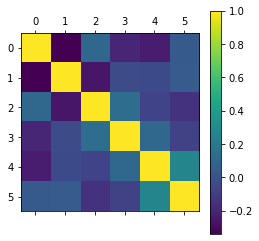

In [14]:
print(covs['obs 0'])
print(measures['obs 0'])

plt.matshow(covs['obs 0'])
plt.colorbar()

In [15]:
ff_correction = data.mol[name_mol].ff_correction

f = data.mol[name_mol].f
fun_forces = jax.jacfwd(ff_correction, argnums=0)
pars = np.ones(2)

measures['ff 0'], covs['ff 0'] = local_density((fun_forces, pars, f), data.mol[name_mol].weights)

[[ 2.37446073 -0.21772175]
 [-0.21772175  0.41964628]]
0.9741821468305136


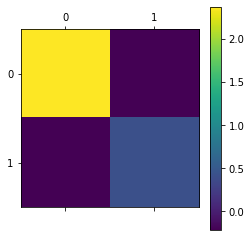

In [16]:
print(covs['ff 0'])
print(measures['ff 0'])

plt.matshow(covs['ff 0'])
plt.colorbar()

In [17]:
vars(result)

result.min_lambdas['AAAA']['backbone1_gamma_3J']

DeviceArray([-0.36735067, -0.06547362], dtype=float64)

In [18]:
weights_new = result.weights_new[name_mol]

In [19]:
measures['obs opt'], covs['obs opt'] = local_density(data.mol[name_mol].g, weights_new)

In [20]:
# notice this is the force-field correction with the reweighted ensemble from Ensemble Refinement
# pars are arbitrarily chosen (they should be zero)
measures['ff opt'], covs['ff opt'] = local_density((fun_forces, pars, f), weights_new)

0.7936978338214815 0.7761417788123444


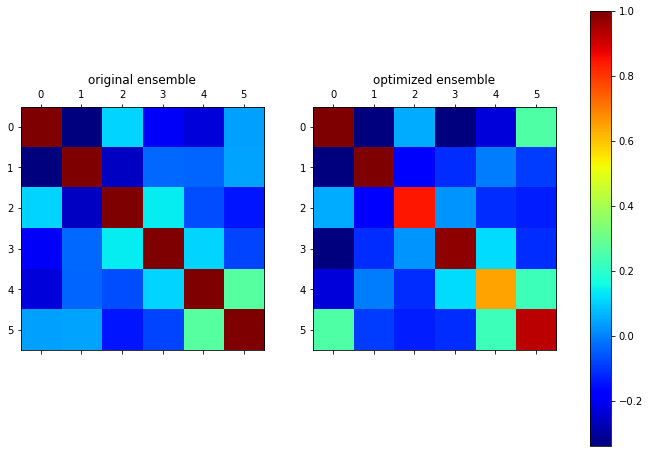

In [21]:
# print(covs['obs opt'])
print(measures['obs 0'], measures['obs opt'])

fig, axs = plt.subplots(1, 2, figsize=(12, 8))

axs[0].matshow(covs['obs 0'], cmap='jet')
axs[0].set_title('original ensemble')

minim = np.min(covs['obs 0'])
maxim = np.max(covs['obs 0'])

im = axs[1].matshow(covs['obs opt'], cmap='jet', vmin=minim, vmax=maxim)
axs[1].set_title('optimized ensemble')

plt.colorbar(im, ax=axs.ravel().tolist())

### 3. sample the posterior at this given value of the hyperparameters
(Ensemble Refinement: sampling ${P_\lambda}$ ensemble; only $\alpha$ is finite, $\alpha=1$)

In [22]:
from MDRefine.MDRefine import loss_function

In [23]:
lambdas = result.min_lambdas
result.loss

DeviceArray(0.54264163, dtype=float64)

In [24]:
flatten_lambda = []
for name_mol in data.properties.system_names:
    flatten_lambda = flatten_lambda + list(
        np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

flatten_lambda = np.array(flatten_lambda)

#### compute and plot

In [25]:
loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=flatten_lambda)

DeviceArray(0.54264163, dtype=float64)

In [26]:
out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=flatten_lambda, if_save=True)

vars(out)

out.weights_new['AAAA']

DeviceArray([0.02690505, 0.01075768, 0.00809472, 0.01207495, 0.00305998,
             0.00651563, 0.01281092, 0.00524987, 0.00267115, 0.0030378 ,
             0.00395543, 0.00668016, 0.00692607, 0.00499431, 0.00302386,
             0.00582803, 0.00315338, 0.01059459, 0.00691244, 0.00415954,
             0.00146177, 0.01040576, 0.00998853, 0.00480053, 0.01332887,
             0.01408155, 0.04271814, 0.00418634, 0.0163348 , 0.01797353,
             0.00637086, 0.01211341, 0.00456591, 0.0029282 , 0.00256414,
             0.00297646, 0.01911655, 0.00211081, 0.00529281, 0.01311685,
             0.02129247, 0.00462854, 0.02132795, 0.01165852, 0.00541997,
             0.00447532, 0.03444298, 0.01413548, 0.00316291, 0.01691253,
             0.00441742, 0.02462426, 0.0153269 , 0.00838556, 0.04133404,
             0.00591116, 0.0018161 , 0.00480269, 0.00567124, 0.0117873 ,
             0.00661316, 0.00487221, 0.00954033, 0.0222085 , 0.00618612,
             0.03868091, 0.0047447 , 0.0070264 , 0.

In [27]:
result.weights_new['AAAA']

DeviceArray([0.02690505, 0.01075768, 0.00809472, 0.01207495, 0.00305998,
             0.00651563, 0.01281092, 0.00524987, 0.00267115, 0.0030378 ,
             0.00395543, 0.00668016, 0.00692607, 0.00499431, 0.00302386,
             0.00582803, 0.00315338, 0.01059459, 0.00691244, 0.00415954,
             0.00146177, 0.01040576, 0.00998853, 0.00480053, 0.01332887,
             0.01408155, 0.04271814, 0.00418634, 0.0163348 , 0.01797353,
             0.00637086, 0.01211341, 0.00456591, 0.0029282 , 0.00256414,
             0.00297646, 0.01911655, 0.00211081, 0.00529281, 0.01311685,
             0.02129247, 0.00462854, 0.02132795, 0.01165852, 0.00541997,
             0.00447532, 0.03444298, 0.01413548, 0.00316291, 0.01691253,
             0.00441742, 0.02462426, 0.0153269 , 0.00838556, 0.04133404,
             0.00591116, 0.0018161 , 0.00480269, 0.00567124, 0.0117873 ,
             0.00661316, 0.00487221, 0.00954033, 0.0222085 , 0.00618612,
             0.03868091, 0.0047447 , 0.0070264 , 0.

ok, it's correct

In [28]:
new_lambdas = flatten_lambda + 0.01*np.random.normal(size=len(flatten_lambda))

out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=new_lambdas, if_save=True)

In [29]:
out.loss

DeviceArray(0.54240324, dtype=float64)

In [30]:
out.loss_explicit

DeviceArray(0.54376897, dtype=float64)

In [31]:
measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])

np.log(measure)

-0.25807609296559886

In [32]:
out.av_g['AAAA']

{'backbone1_gamma_3J': DeviceArray([ 0.49814157, -0.16392782], dtype=float64),
 'backbone2_beta_epsilon_3J': DeviceArray([ 0.53492797, -0.02512379], dtype=float64),
 'sugar_3J': DeviceArray([-0.38140129, -0.48085362], dtype=float64)}

In [33]:
values = []
avgs = []

for i in range(500):
    
    new_lambdas = flatten_lambda + 0.01*np.random.normal(size=len(flatten_lambda))

    out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=new_lambdas, if_save=True)
    measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])

    values.append([out.loss_explicit, np.log(measure)])
    avgs.append(out.av_g['AAAA']['backbone1_gamma_3J'])

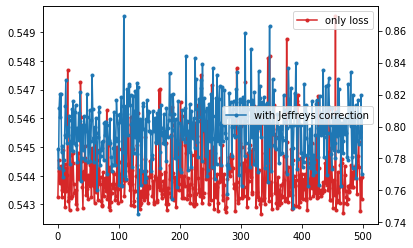

In [34]:
values = np.array(values)

fig, ax1 = plt.subplots()

ax1.plot(values[:, 0], '.-', color='tab:red', label='only loss')
ax1.legend(loc='upper right')

ax2 = ax1.twinx()
ax2.plot(values[:, 0] - values[:, 1], '.-', color='tab:blue', label='with Jeffreys correction')

ax2.legend(loc='right')


In [35]:
avgs = np.array(avgs)

0.5239325714503147 0.5239092266255013
-0.16690772663926995 -0.16704604933876718


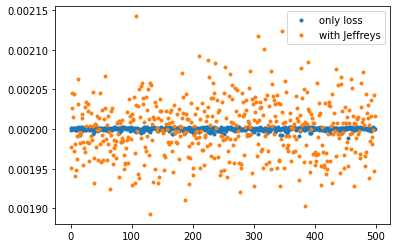

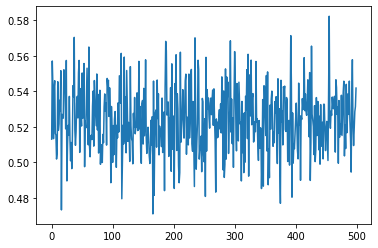

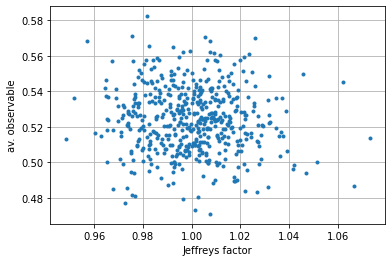

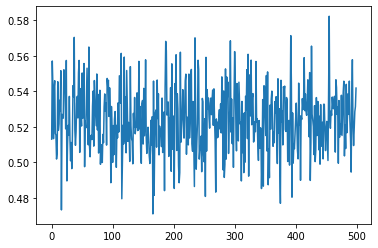

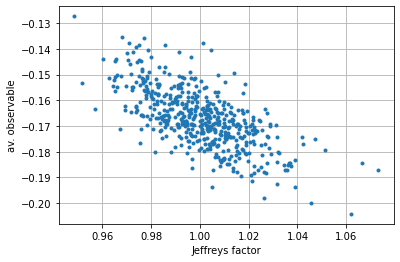

In [36]:
bayes_weight = np.exp(-values[:, 0])
bayes_weight = bayes_weight/np.sum(bayes_weight)

bayes_weight2 = np.exp(-values[:, 1])
bayes_weight2 = bayes_weight2/np.sum(bayes_weight2)

plt.plot(bayes_weight, '.', label='only loss')
plt.plot(bayes_weight2, '.', label='with Jeffreys')
plt.legend()

for i_obs in range(avgs.shape[1]):

    bayes_av = np.sum(bayes_weight*avgs[:, i_obs])
    bayes_av2 = np.sum(bayes_weight2*avgs[:, i_obs])

    plt.figure()
    plt.plot(avgs[:, 0])

    print(bayes_av, bayes_av2)

    plt.figure()
    plt.plot(bayes_weight2/bayes_weight, avgs[:, i_obs], '.')
    plt.xlabel('Jeffreys factor')
    plt.ylabel('av. observable')
    plt.grid()

#### Metropolis sampling

In [37]:
x0 = flatten_lambda

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([0.01])}

def energy_fun(lambdas, if_Jeffreys):
    
    out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=lambdas, if_save=True)
    
    energy = out.loss_explicit

    av_g = unwrap_2dict(out.av_g)[0]

    if if_Jeffreys:
        name_mol = list(out.weights_new.keys())[0]
        measure, cov = local_density(data.mol[name_mol].g, out.weights_new[name_mol])
        energy -= np.log(measure)
    
    return energy, av_g

In [52]:
energy_function = {'fun': energy_fun, 'args': ([True])}
sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=5000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [53]:
energy_function = {'fun': energy_fun, 'args': ([False])}
sampling_noJ = run_Metropolis(x0, proposal_full, energy_function, n_steps=5000)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


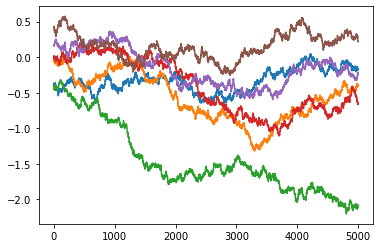

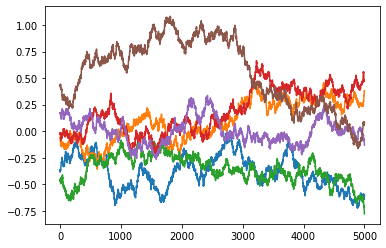

In [54]:
for i in range(6):

    plt.plot(sampling_J[0][:, i], '-', label='with Jeffreys prior')
    # plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

# plt.savefig('../Figures/lambdas_J.pdf', format="pdf", bbox_inches="tight")

plt.figure()

for i in range(6):
    plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

# plt.savefig('../Figures/lambdas_noJ.pdf', format="pdf", bbox_inches="tight")

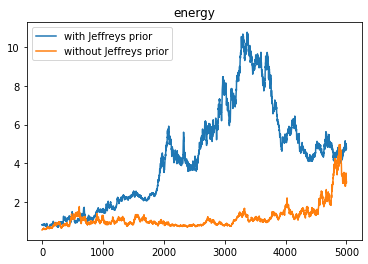

In [55]:
plt.plot(sampling_J[1], '-', label='with Jeffreys prior')
plt.plot(sampling_noJ[1], '-', label='without Jeffreys prior')
plt.title('energy')
plt.legend()
# plt.text(2000, 0, s='av. acceptance: with J.' + str(sampling_J[2]) + '; without J.' + str(sampling_noJ[2]))

# plt.savefig('../Figures/energies.pdf', format="pdf", bbox_inches="tight")


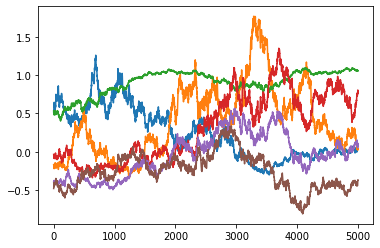

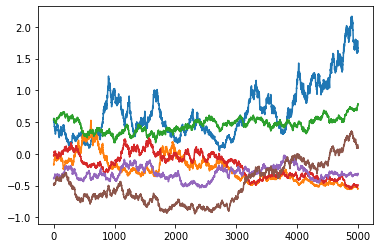

In [56]:
plt.plot(sampling_J[3])

plt.figure()
plt.plot(sampling_noJ[3])

#### try in lower dimensionality

In [51]:
vars(data.mol['AAAA'])

{'temperature': 1.0,
 'gexp': {'backbone1_gamma_3J': DeviceArray([[ 0.6510965 ,  0.70121354],
               [-0.08500965,  0.60379414],
               [ 0.03650918,  1.11244602],
               [-0.52931627,  0.81365266],
               [-0.00961196,  0.92763887],
               [-0.0484394 ,  0.71896851],
               [-0.18516992,  0.59697546],
               [ 0.03907911,  0.93452099]], dtype=float64),
  'backbone2_beta_epsilon_3J': DeviceArray([[ 0.777321  ,  0.50678736],
               [-0.0146585 ,  0.69697912],
               [-0.90169722,  1.02790237],
               [ 0.73055686,  0.52498343],
               [-0.34547188,  0.68585621],
               [-0.7305197 ,  0.82189291],
               [ 1.05279132,  0.58206594],
               [ 0.12842434,  0.85050804],
               [-1.01044102,  0.78101981]], dtype=float64),
  'sugar_3J': DeviceArray([[-0.40381679,  0.34622015],
               [-1.0888193 ,  1.20996958],
               [-0.61373679,  0.37060322],
              

In [52]:
s = 'backbone1_gamma_3J'

assert list(data.mol.keys()) == ['AAAA']
assert list(data.mol['AAAA'].g.keys()) == [s]

data.mol['AAAA'].gexp[s] = data.mol['AAAA'].gexp[s][:2, :]
data.mol['AAAA'].g[s] = data.mol['AAAA'].g[s][:, :2]
# data.mol['AAAA'].normg_mean[s] = data.mol['AAAA'].normg_mean[s][:2]
# data.mol['AAAA'].normg_std[s] = data.mol['AAAA'].normg_std[s][:2]
data.mol['AAAA'].n_experiments[s] = 2

AssertionError: 

In [15]:
out = minimizer(data, alpha=1)

vars(out)

{'loss': DeviceArray(0.11523865, dtype=float64),
 'min_lambdas': {'AAAA': {'backbone1_gamma_3J': DeviceArray([-0.32268477, -0.01043889], dtype=float64)}},
 'minis': {'AAAA':       fun: -0.1152386542106145
   hess_inv: array([[0.38770197, 0.05015591],
         [0.05015591, 0.91372151]])
        jac: array([-0.00018545,  0.00024437])
    message: 'Optimization terminated successfully.'
       nfev: 6
        nit: 4
       njev: 6
     status: 0
    success: True
          x: array([-0.32268477, -0.01043889])},
 'time': 0.5969316959381104,
 'D_KL_alpha': {'AAAA': DeviceArray(0.08967682, dtype=float64)},
 'abs_difference': {'AAAA': DeviceArray(1.16872218e-07, dtype=float64)},
 'av_g': {'AAAA': {'backbone1_gamma_3J': DeviceArray([ 0.49261772, -0.08905969], dtype=float64)}},
 'chi2': {'AAAA': {'backbone1_gamma_3J': DeviceArray(0.05112391, dtype=float64)}},
 'logZ_new': {'AAAA': DeviceArray(0.06835373, dtype=float64)},
 'weights_new': {'AAAA': DeviceArray([0.0010913 , 0.00356539, 0.00092513, 

In [16]:
x_min = out.min_lambdas

x_min

{'AAAA': {'backbone1_gamma_3J': DeviceArray([-0.32268477, -0.01043889], dtype=float64)}}

In [17]:
def flat_lambda(lambdas):

    flatten_lambda = []
    for name_mol in data.properties.system_names:
        flatten_lambda = flatten_lambda + list(
            np.hstack([lambdas[name_mol][k] for k in data.mol[name_mol].n_experiments.keys()]))

    flatten_lambda = np.array(flatten_lambda)

    return flatten_lambda

In [18]:
x_min = flat_lambda(x_min)

x_min

array([-0.32268477, -0.01043889])

In [19]:
n = 30
delta = 1

x = np.linspace(x_min[0] - delta, x_min[0] + delta, n)
y = np.linspace(x_min[1] - delta, x_min[1] + delta, n)

grid = np.meshgrid(x, y)[0]

In [23]:
sh = grid.shape

grid_vals_J = np.zeros(sh)
grid_vals_noJ = np.zeros(sh)

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.zeros(2), data, regularization=None, alpha=1, fixed_lambdas=np.array([x[i], y[j]]), if_save=True)
        grid_vals_noJ[i, j] = out.loss_explicit

        measure, cov = compute_sqrt_det(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)


In [258]:
vmax

13.119052571589295

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


0.1411825716663658 23.944606399470103


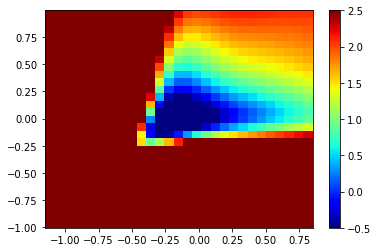

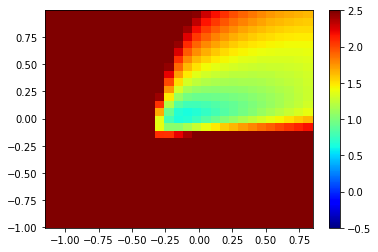

In [95]:
# matplotlib.rcParams['pcolor.shading']

# vmin = np.min(grid_vals_J)
# # vmax = np.max(grid_vals_J)
# vmax = vmin + 8

vmin = -0.5
vmax = 2.5

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


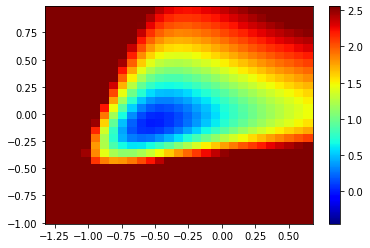

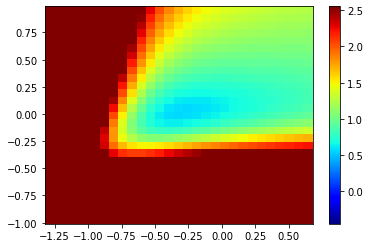

In [42]:
# matplotlib.rcParams['pcolor.shading']

vmin = np.min(grid_vals_J)
# vmax = np.max(grid_vals_J)
vmax = vmin + 3

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.colorbar()

In [90]:
x0 = x_min

In [24]:
energy_function = {'fun': energy_fun, 'args': ([True])}

proposal_full = {'fun': proposal, 'args': ([2])}

sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

NameError: name 'energy_fun' is not defined

In [92]:
energy_function = {'fun': energy_fun, 'args': ([False])}
sampling_noJ = run_Metropolis(x0, proposal_full, energy_function, n_steps=500)

0
100
200
300
400


Text(0.5, 1.0, 'lambdas without Jeffreys prior')

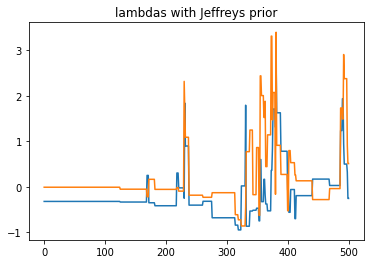

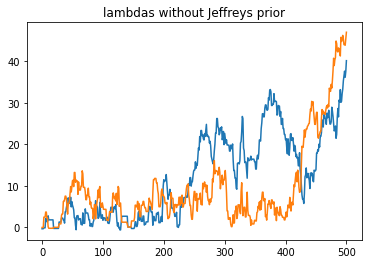

In [66]:
for i in range(2):

    plt.plot(sampling_J[0][:, i], '-')
    # plt.plot(sampling_noJ[0][:, i], '-', label='without Jeffreys prior')
    # plt.legend()

plt.title('lambdas with Jeffreys prior')

# plt.savefig('../Figures/lambdas_J.pdf', format="pdf", bbox_inches="tight")

plt.figure()

for i in range(2):
    plt.plot(sampling_noJ[0][:, i], '-')
    # plt.legend()

plt.title('lambdas without Jeffreys prior')

# plt.savefig('../Figures/lambdas_noJ.pdf', format="pdf", bbox_inches="tight")

av. acceptance: with J.0.094; without J.0.74


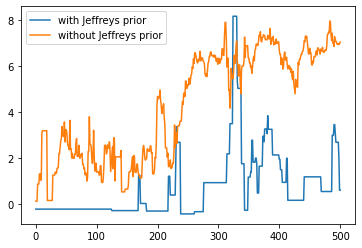

In [67]:
plt.plot(sampling_J[1], '-', label='with Jeffreys prior')
plt.plot(sampling_noJ[1], '-', label='without Jeffreys prior')
plt.legend()

s = 'av. acceptance: with J.' + str(sampling_J[-1]) + '; without J.' + str(sampling_noJ[-1])
# plt.text(2000, 0, s=s)

print(s)

# plt.savefig('../Figures/energies.pdf', format="pdf", bbox_inches="tight")


### 4. sampling force-field corrections

(sampling $P_\phi$ ensemble; only $\beta$ is finite, $\beta=1$)

In [35]:
result = minimizer(data, regularization={'force_field_reg': 'KL divergence'}, beta=1)

New evaluation:
loss:  11.612877669764105
gradient:  [-0.75592143] 

New evaluation:
loss:  11.659845830748091
gradient:  [0.33955028] 

New evaluation:
loss:  11.535323417245781
gradient:  [0.0435029] 

New evaluation:
loss:  11.534874187598614
gradient:  [0.01823386] 

New evaluation:
loss:  11.53478350116777
gradient:  [-0.00103383] 

New evaluation:
loss:  11.53478321763859
gradient:  [2.25814969e-05] 



In [36]:
pars = result.pars

pars

array([0.24187507])

In [37]:
print('av. values: ', data.mol['AAAA'].normg_mean)
print('\nexp. values: ', data.mol['AAAA'].gexp)

print('\nrefined av. values: ', result.av_g)

AttributeError: 'data_class' object has no attribute 'normg_mean'

In [38]:
deltap = 20

pars1 = np.arange(pars[0] - deltap, pars[0] + deltap, 0.3)

sum_dict = lambda my_dict : np.sum([x for x in my_dict.values()])

name_mol = data.properties.system_names[0]

ff_correction = data.mol[name_mol].ff_correction
fun_forces = jax.jacfwd(ff_correction, argnums=0)

loss = []
av_g = []
reg_ff = []
density = []
chi2 = []

for p1 in pars1:

    out = loss_function(np.array([p1]), data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
    
    loss.append(out.loss)
    av_g.append(unwrap_2dict(out.av_g)[0])
    reg_ff.append(out.reg_ff['AAAA'])

    chi2.append(sum_dict(out.chi2['AAAA']))

    # out.chi2['AAAA']
    density.append(local_density((fun_forces, np.array([p1]), data.mol[name_mol].f, data.mol[name_mol].g), out.weights_new[name_mol])[0])



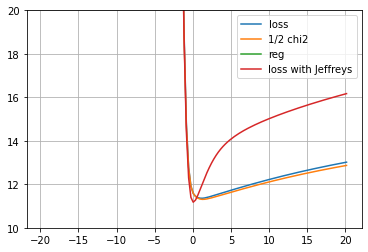

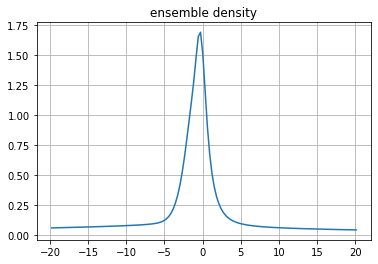

In [39]:
plt.plot(pars1, loss, label='loss')
plt.plot(pars1, 1/2*np.array(chi2), label='1/2 chi2')
plt.plot(pars1, reg_ff, label='reg')
plt.plot(pars1, loss - np.log(density), label='loss with Jeffreys')

# plt.yscale('log')
plt.ylim([10, 20])
plt.legend()
plt.grid()

plt.figure()
plt.plot(pars1, density)
plt.title('ensemble density')
plt.grid()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


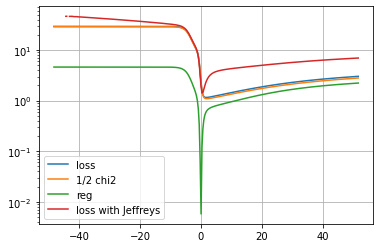

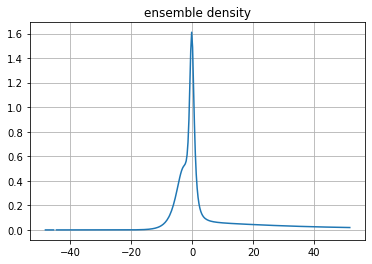

In [53]:
plt.plot(pars1, loss, label='loss')
plt.plot(pars1, 1/2*np.array(chi2), label='1/2 chi2')
plt.plot(pars1, reg_ff, label='reg')
plt.plot(pars1, loss - np.log(density), label='loss with Jeffreys')

plt.yscale('log')
plt.legend()
plt.grid()

plt.figure()
plt.plot(pars1, density)
plt.title('ensemble density')
plt.grid()

In [26]:
deltap = 10

pars1 = np.arange(pars[0] - deltap, pars[0] + deltap, 0.3)
pars2 = np.arange(pars[1] - deltap, pars[1] + deltap, 0.3)

loss = {}
av_g = {}
reg_ff = {}
density = {}

for p1 in pars1:
    print(p1)

    loss[p1] = {}
    av_g[p1] = {}
    reg_ff[p1] = {}
    density[p1] = {}

    for p2 in pars2:
        out = loss_function(np.array([p1, p2]), data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
        
        loss[p1][p2] = out.loss
        av_g[p1][p2] = unwrap_2dict(out.av_g)[0]
        reg_ff[p1][p2] = out.reg_ff['AAAA']

        density[p1][p2] = local_density((fun_forces, np.array([p1, p2]), data.mol[name_mol].f, data.mol[name_mol].g), out.weights_new[name_mol])


-8.177663687307177
-7.8776636873071775
-7.577663687307178
-7.277663687307178
-6.977663687307178
-6.677663687307178
-6.377663687307178
-6.0776636873071785
-5.777663687307179
-5.477663687307179
-5.177663687307179
-4.877663687307179
-4.577663687307179
-4.27766368730718
-3.97766368730718
-3.67766368730718
-3.37766368730718
-3.0776636873071803
-2.7776636873071805
-2.4776636873071807
-2.177663687307181
-1.877663687307181
-1.5776636873071812
-1.2776636873071814
-0.9776636873071816
-0.6776636873071817
-0.3776636873071819
-0.07766368730718298
0.22233631269281773
0.5223363126928184
0.8223363126928174
1.1223363126928163
1.422336312692817
1.7223363126928177
2.0223363126928167
2.3223363126928156
2.6223363126928163
2.922336312692817
3.222336312692816
3.522336312692815
3.8223363126928156
4.122336312692816
4.422336312692815
4.722336312692814
5.022336312692815
5.322336312692816
5.6223363126928145
5.9223363126928135
6.222336312692814
6.522336312692815
6.822336312692814
7.122336312692813
7.42233631269281

In [27]:
flatten = lambda my_dict : np.array([[my_dict[l1][l2] for l1 in pars1] for l2 in pars2])

loss = flatten(loss)
density = np.array([[density[l1][l2][0] for l1 in pars1] for l2 in pars2])

av_g = flatten(av_g)

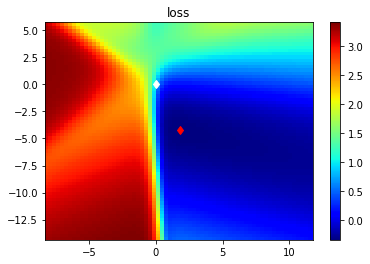

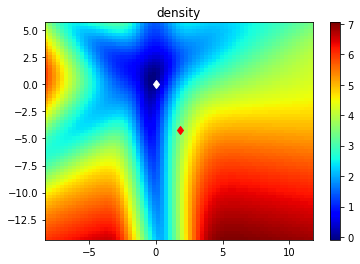

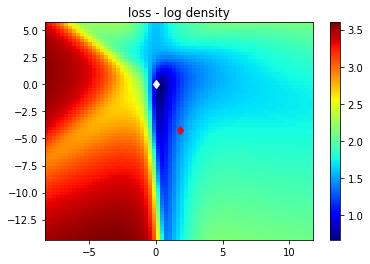

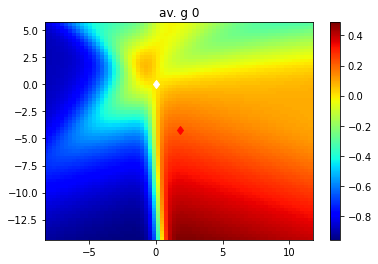

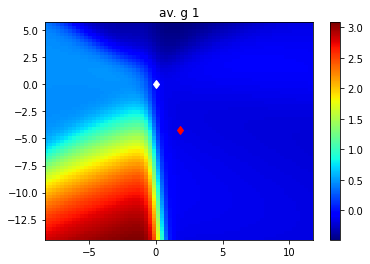

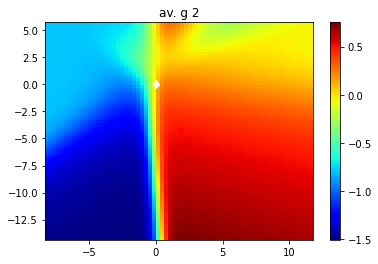

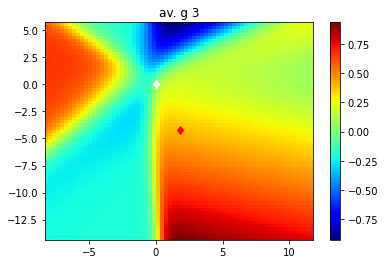

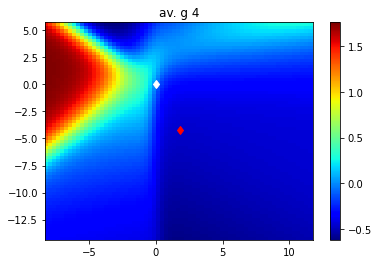

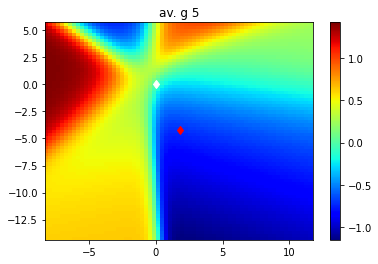

In [28]:
matplotlib.rcParams['pcolor.shading'] = 'auto'

plt.figure()
plt.title('loss')
plt.pcolormesh(pars1, pars2, np.log(loss), cmap='jet')  # , vmax=.0)
plt.colorbar()
plt.plot(pars[0], pars[1], 'dr')
plt.plot(0, 0, 'dw')

plt.figure()
plt.title('density')
plt.pcolormesh(pars1, pars2, -np.log(density), cmap='jet')
plt.colorbar()
plt.plot(pars[0], pars[1], 'dr')
plt.plot(0, 0, 'dw')

plt.figure()
plt.title('loss - log density')
plt.pcolormesh(pars1, pars2, np.log(loss - np.log(density)), cmap='jet')
plt.colorbar()
plt.plot(pars[0], pars[1], 'dr')
plt.plot(0, 0, 'dw')

for i in range(6):
    plt.figure()
    plt.title('av. g %i' % i)
    plt.pcolormesh(pars1, pars2, av_g[:, :, i], cmap='jet')
    plt.colorbar()
    plt.plot(pars[0], pars[1], 'dr')
    plt.plot(0, 0, 'dw')

In [29]:
x0 = pars

def proposal(x0, dx=0.01):
    x_new = x0 + dx*np.random.normal(size=len(x0))
    return x_new

proposal_full = {'fun': proposal, 'args': ([2.0])}

name_mol = data.properties.system_names[0]

ff_correction = data.mol[name_mol].ff_correction
fun_forces = jax.jacfwd(ff_correction, argnums=0)


def energy_fun(pars, which_measure):
    
    out = loss_function(pars, data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
    
    energy = out.loss  # which is loss_explicit if alpha is infinite

    av_g = unwrap_2dict(out.av_g)[0]

    if which_measure == 'jeffreys' or which_measure == 'dirichlet':
        my_tuple = (fun_forces, pars, data.mol[name_mol].f)
        measure, cov = local_density(my_tuple, out.weights_new[name_mol], which_measure=which_measure)
        energy -= np.log(measure)
    
    elif which_measure == 'average':
        my_tuple = (fun_forces, pars, data.mol[name_mol].f, data.mol[name_mol].g)
        measure, cov = local_density(my_tuple, out.weights_new[name_mol], which_measure=which_measure)
        energy -= np.log(measure)
    
    return energy, av_g

In [ ]:
fun_forces = jax.jacfwd(ff_correction, argnums=0)


In [30]:
energy_function = {'fun': energy_fun, 'args': ([None])}
sampling_noJ = run_Metropolis(x0, proposal_full, energy_function, n_steps=1000)

energy_function = {'fun': energy_fun, 'args': (['jeffreys'])}
sampling_J = run_Metropolis(x0, proposal_full, energy_function, n_steps=1000)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


acceptance:  0.483 0.866


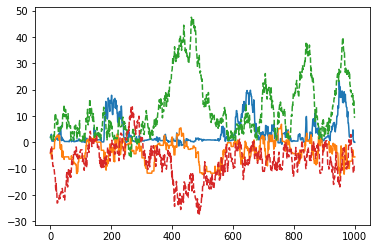

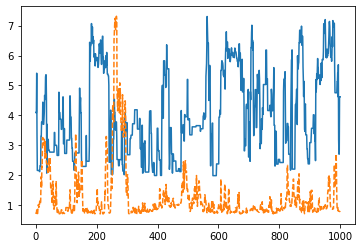

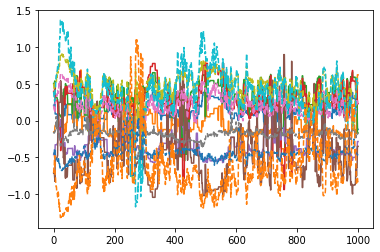

In [69]:
plt.plot(sampling_J[0], '-')
plt.plot(sampling_noJ[0], '--')

plt.figure()
plt.plot(sampling_J[1], '-')
plt.plot(sampling_noJ[1], '--')

print('acceptance: ', sampling_J[2], sampling_noJ[2])

plt.figure()
plt.plot(sampling_J[3], '-')
plt.plot(sampling_noJ[3], '--')

{'AAAA': {'backbone1_gamma_3J': DeviceArray([ 0.20664095, -0.15440301], dtype=float64), 'backbone2_beta_epsilon_3J': DeviceArray([0.50376395, 0.39505217], dtype=float64), 'sugar_3J': DeviceArray([-0.46122367, -0.71339527], dtype=float64)}}


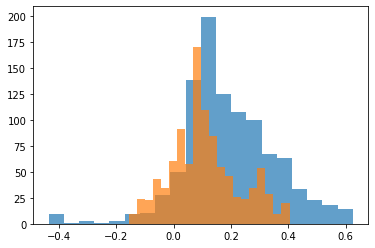

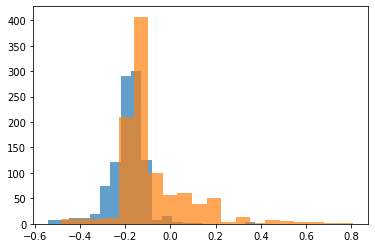

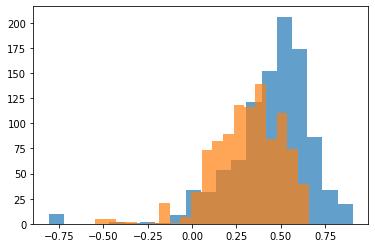

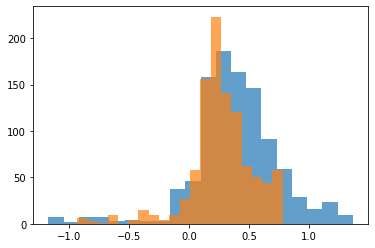

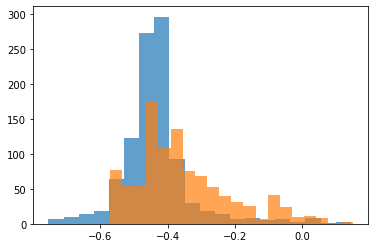

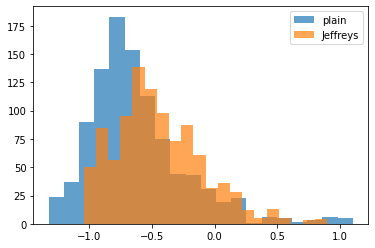

In [75]:
for i in range(sampling_J[3].shape[1]):
    plt.figure()
    plt.hist(sampling_noJ[3][:, i], bins=20, alpha=0.7, label='plain')
    plt.hist(sampling_J[3][:, i], bins=20, alpha=0.7, label='Jeffreys')

plt.legend()

print(result.av_g)

since we have just 2 coefficients, we can plot the posterior

In [71]:
n = 30
delta = 10

x = np.linspace(x0[0] - delta, x0[1] + delta, n)
y = np.linspace(x0[1] - delta, x0[1] + delta, n)

grid = np.meshgrid(x, y)[0]

In [82]:
sh = grid.shape

grid_vals_J = np.zeros(sh)
grid_vals_noJ = np.zeros(sh)
grid_vals_avg = np.zeros((sh[0], sh[1], 8))

name_mol = 'AAAA'

for i in range(sh[0]):
    for j in range(sh[1]):
        out = loss_function(np.array([x[i], y[j]]), data, regularization={'force_field_reg': 'KL divergence'}, beta=0.1, if_save=True)
        grid_vals_noJ[i, j] = out.loss
        grid_vals_avg[i, j, :] = np.array(unwrap_2dict(out.av_g)[0])

        measure, cov = compute_sqrt_det(data.mol[name_mol].g, out.weights_new[name_mol])
        grid_vals_J[i, j] = grid_vals_noJ[i, j] - np.log(measure)


/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


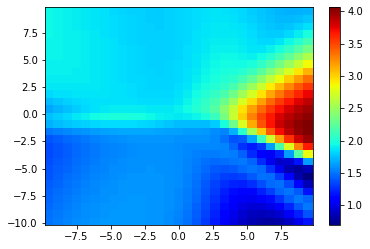

In [90]:
plt.pcolormesh(x, y, grid_vals_avg[:, :, 7], cmap='jet')
plt.colorbar()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


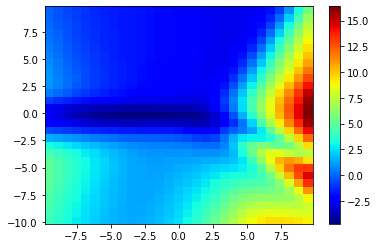

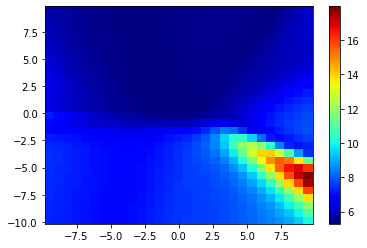

In [73]:
# plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.pcolormesh(x, y, grid_vals_J, cmap='jet')
plt.colorbar()

plt.figure()
# plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet')
plt.colorbar()

/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/u/i/igilardo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app


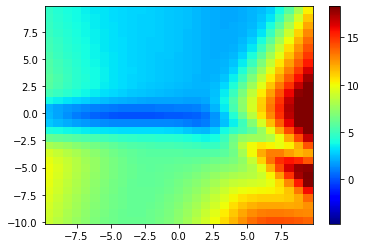

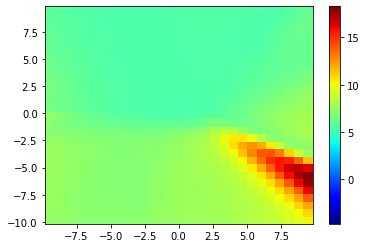

In [74]:
# matplotlib.rcParams['pcolor.shading']

vmin = np.min(grid_vals_J)
vmax = np.max(grid_vals_J)
# vmax = vmin + 8

# vmin = -0.5
# vmax = 2.5

plt.pcolormesh(x, y, grid_vals_J - vmin, cmap='jet', vmin=vmin, vmax=vmax)
# plt.pcolormesh(x, y, grid_vals_J, cmap='jet')
plt.colorbar()

plt.figure()
plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet', vmin=vmin, vmax=vmax)
# plt.pcolormesh(x, y, grid_vals_noJ - vmin, cmap='jet')
plt.colorbar()

# print(np.min(grid_vals_noJ), np.max(grid_vals_noJ))